# Machine Learning @ UWr 2020

**Lecture 05**

In the previous lecture we have seen how to derive classification and regression models usint the MLE and MAP inference principles. In particular we have seen that we can:
- construct a linear reagression model with the MSE loss function by deriving the MLE estimator to a model which assumes Gaussian error distribution.
- construct a linear regression model with the sum of absolute values error function, which is the MLE estimator under a Laplace error assumption
- construct binary and multiclass classification models using logistic sigmoid and softmax squashing functions to map scores computed by a linear model to discrete probability distributions.

Moreover, we have seen that the choice of assumptions matters. Gaussian and Laplace noise assumptions lead to different outlier robustness, and we have introduced the Huber loss as a compromise between the efficiency of the least squares estimator and the robustness of the absolute value one.

Finally, we have seen that model priors enforced using the MAP nference pronciple lead to regularized models, such as the Ridge Regression.

In this note we will spend more time on the regularization term, exploring the difference between Gaussian and Laplace priors, which lead to, respectively, a sum of squares (L2-norm) or sum of absolute vales (L1-norm) regularization terms.

## Feature Selection

We build models based on data to answer questions. So far, our basic question was: `What will happen on new data?` However, there are follow-up questions:
- `Why will this happen`
- `What part of the input is responsible` for this answer.

This leads us to the problem of salient feature selection: select the features (elements of `x`) which contain the most of predictive power, and leave out the other ones. Ideally feature selection will yield models which are:
- as accurate than the ones which use full feature set,
- easier to interpret than the ones that use the full feature set.

Please note, that feature selection is a form of model regularization -- we prefer models which use fewer inputs. If this helps, or harms our model depends on the nature of the features we have:
- if the data has a few important features, and many noisy ones, feature selection mey help, because it will combat the curse of dimensionality by discarding the noisy ones.
- if the data has many noisy features which are nevertheless correlated with the desired outcome, we may need to average all of them to get good results. In this case, feature selection may hurt us.

Thus, while it may sometimes happen that feature selection yields a model which is both smaller and more accurate, quite often we are content with a model that we understand better, even at the cost of a decrease in accuracy. It all depends on the data.

Nevertheless, feature selection is an important task in machine learning, and an important tool in our aresnal for better data understanding.

### Feature Selection as an Optimization Problem

At its core, feature selection is an optimization problem:

> Feature Selection: Limit the number of features, subject to an acceptable decrease of model performance.

Features can interact, and their joint preictive power may be greater than each of the features alone. For instance, consider this XOR domain, which contains 4, equally probable data samples:

| $x_1$ | $x_2$ | $y$ |
|:-----:|:-----:|:---:|
|   0   |   0   |  0  |
|   0   |   1   |  1  |
|   1   |   0   |  1  |
|   1   |   1   |  0  |

Observation: $y$ is independent from $x_1$ and $y$ is independent from $x_2$. Only when $x_1$ and $x_2$ are considered **jointly**, $y$ becomes dependent on them!

This simple example shows us, that optimal feature selection is a difficult combinatorial problem. However, data are not always as malicious as the XOR example, and the optimization can be performed using some heuristic approximations.

### Scoring-based methods for Feature Selection

Some basic feature selection methods compute feature importance scores. Examples include:
- computing the correlation between each feature and the target
- computing the [Mutual Information](https://en.wikipedia.org/wiki/Mutual_information) between each feature and the target.

The features are then selected in the order of the importance scores.

The simple scoring methods have two drawbacks: first, the selected dependency measure may be limited to the kind of interaction it detects (e.g. correlation detects linear dependencies only)  or it may be hard to compute (e.g. mutual information requires intgating over the joint probability distribution of the feature and target). Second, it ignores co-dependencies between features: as shown in the XOR example, some features must be considered jointly.



### Wrapper Feature Selection Methods

The wrapper methods attempt to directly solve the above optimization problem, by judging the importance of each feature by its impact on the model's accurracy. Typical approaches are:
- **Forward selection**: we start with an empty feature set, then in a loop: extend the current selection with a single feature, record the impact on the accurracy, greedily extend the selection with the the bes teafure in this round and repat.
- **Backward selection**: start with a selection of all features. In a loop, try removing each feature and record the performance change. Remove the feature causing the least harm.

Both approaches are greedy and may fail in the presence of clusters of features which must be selected jointly, however their repeated application may return sensible subsets of features. Often, more advenced combinatorial optimization approaches are used, such as **genetic programming** which tries to optimize the set of selected features using set mutation and crossover opeartions.

## Regularization for Feauture Selection

Our preference for a small set of used features can also be expressed using a regularization term. 

Consider the optimization problem we are solving:
$$
    \underset{\Theta}{\mathrm{argmin}} \sum_{x,y}nll(x, y, \Theta) + \lambda r(\Theta)
$$

We could set $r(\Theta) = ||\Theta||_0 = \sum_j[\Theta_j \neq 0]$ to directly minimize the number of non-zero elemnts of $\Theta$, which amounts to minimizing the number of features that matter.

Unfortunately, minimizing the $L_0$ norm is again a computationally itractable combinatorial optimization problem. However, minimizing the $L_1$ norm, or the sum of absolute values, often also yields sparse solutions. To understand why, consider the cartoon below.


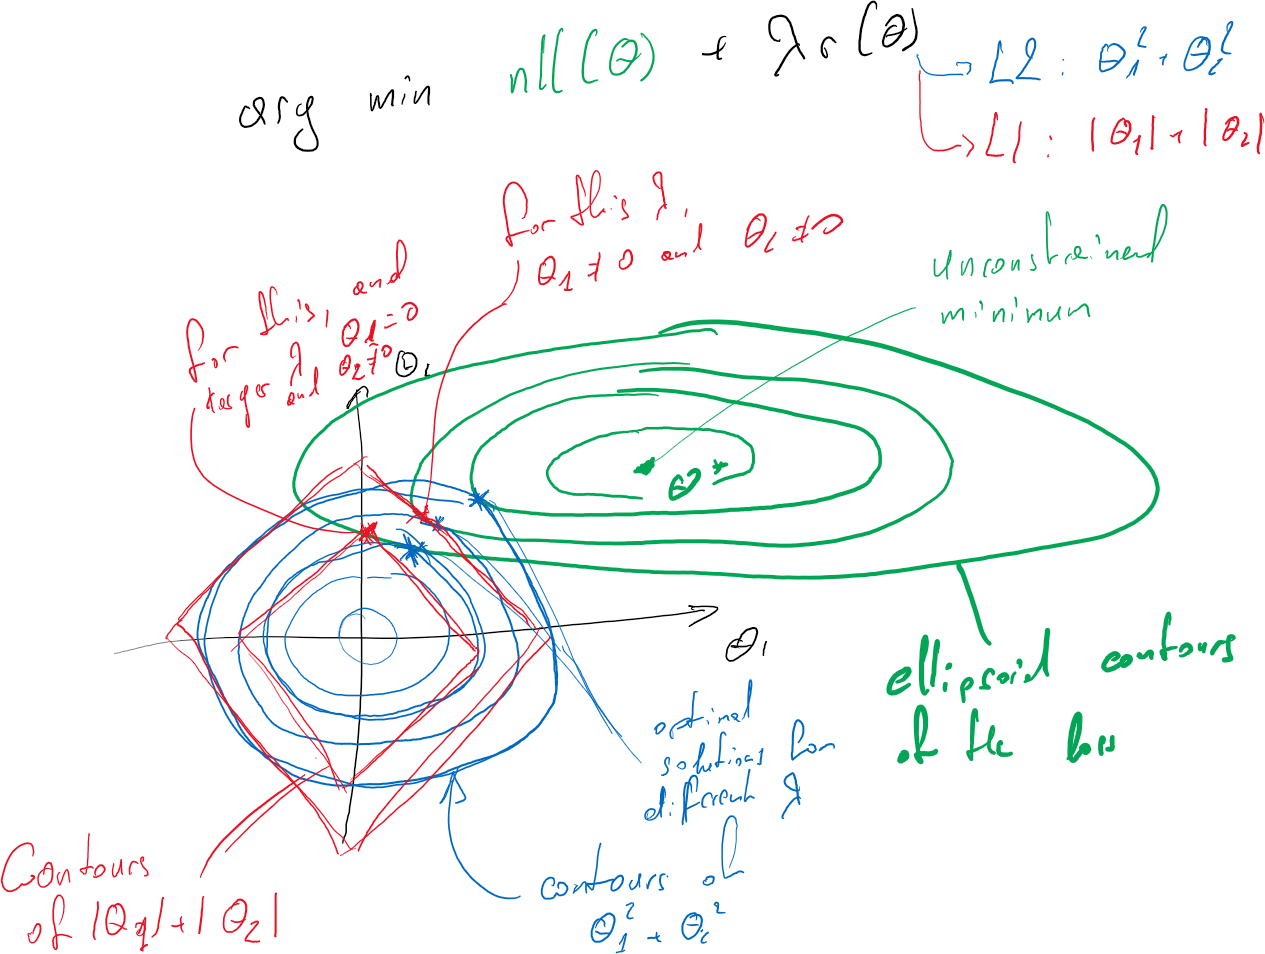

In green we see ellipsoidal contours of the negative log likelihood (the MSE criteriion gives rise to wllipsoid contours, other negative log likelohood functions look similar).

Blue circles represent the contours with equal value of the $L_2$ norm of $\Theta$, i.e. the sum of squares of elements of theta. Each value of the $\lambda$ hyperparameter corresponds to one optimal point in which the two countours touch: it is not possible to dencreas the nll, without increasing the regularizatoin term and vice versa. The circles touch the at points for which both $\Theta_1$ and $\Theta_2$ are non-zero. As lambda is changed, both gro or both shrink, but both stay non-zero. The solution is not sparse.

On the other hand, the red squares show the contours of the $L_1$ norm. Here, for small $\lambda$ (large diamonds) both $\Theta_1$ and $\Theta_2$ are nonzero, however as lambda increases, the red diamonds start to meet the green ellipsoids at their corners. Hence, for sufficiently large $\lambda$ we will have $\Theta_1=0$. Minimizing th esum of absolute values yields sparse solutions!

However, efficient algorithms exist for minimizing the sum of absolute values: this loss function has a derivative everywhere except on the zero-crossings, and is convex. 

Particulary common is the case of MSE regression with $L_1$ regularization, called the Lasso criterion.

$$
\underset{\Theta}{\mathrm{argmin}} \frac{1}{N}\sum_i(y^{(i)} - x^{(i)}\Theta)^2 + \lambda \sum_j|\Theta_j|
$$

The name refferrs to usig the rope Lasso: when $\lambda \rightarrow 0$ the regularization term matters little, and the "Lasso" over $\Theta$ is wide open. As $\lambda$ starts to increase, the Lasso closes down, zeroing the coefficients of some not needed features.

In [4]:
import numpy as np
import numpy.linalg as npl
import pandas as pd
import scipy.stats as sstats

import sklearn.linear_model

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

### Gaussian vs Laplace

Finally, we will now compare the $L_1$ and $L_2$ terms from a probabilistic perspective. As you may recall, $L_2$ regularization corresponds to a Normal prior asumptions, while $L_1$ reguarization corresponds to a Laplace prior.

Below we plot the two PDFs on a logarithmic scale. The two difstributions have matched mean (0) and standard deviations (1).

We can see that compared with the standard normal distribution, the Laplace has more mass near zero, less mass in the small nonzero range, then more mass in the tails. This means, that it will favor model with sparse coefficients: a few large $\Theta_j$ and many zero ones.  On the other hand, a standard normal model has less probability mass in the tails - it favors small, but nonzero values over very large ones. Thus models trained with $L_2$ regularization will tend to use all features with small, similar coefficient values.

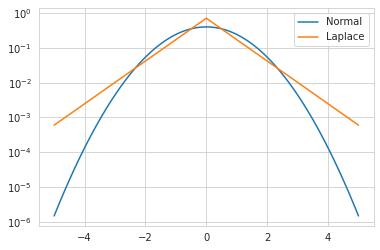

In [12]:
xx=np.linspace(-5, 5, 101)
plt.semilogy(xx, sstats.norm.pdf(xx), label='Normal')
plt.semilogy(xx, sstats.laplace.pdf(xx, scale=1/np.sqrt(2)), label='Laplace')
plt.legend()


### Forward stagewise

Before we get back to the Lasso model, we will consider a somewhat heuristic procedure that tries to trace the full regularization curve of a regression problem:

1. Start with $\Theta=0$, which corresponds to $\lambda \rightarrow \infty$.
2. In a loop choose the feature which has the strongest correlation with the error and change its corresponding coefficient by a tiny amount.

Upon completion, the **Forward Stagewise** procedure will show which features are important and which reduce the loss in roughly the same way. Below we deomnstrate it on a cancer data from the inventors of Lasso.

In [14]:
# Load the data

cancer_df = pd.read_csv(
    'https://web.stanford.edu/~hastie/ElemStatLearn/datasets/prostate.data',
    sep='\t', header=0, index_col=0)

train_id = cancer_df['train']
del cancer_df['train']

# Standardize the whole data, as per its readme
# https://web.stanford.edu/~hastie/ElemStatLearn/datasets/prostate.info.txt
# NB, usually you should standardize based on train set only!!

cancer_df -= cancer_df.mean(0, numeric_only=True)
cancer_df /= cancer_df.std(0, numeric_only=True)

cancer_train_df = cancer_df[train_id=='T']
cancer_test_df = cancer_df[train_id=='F']

X_cols = [c for c in cancer_df.columns if c!='lpsa']
Y_col = 'lpsa'

print(f'Train nas {len(cancer_train_df)} saples\n'
      f'Test nas {len(cancer_test_df)} saples')

cancer_train_df.head()

Train nas 67 saples
Test nas 30 saples


,lcavol,lweight,age,lbph,svi,lcp,gleason,pgg45,lpsa
1,-1.637356,-2.006212,-1.862426,-1.024706,-0.522941,-0.863171,-1.042157,-0.864467,-2.520226
2,-1.988980,-0.722009,-0.787896,-1.024706,-0.522941,-0.863171,-1.042157,-0.864467,-2.287827
3,-1.578819,-2.188784,1.361163,-1.024706,-0.522941,-0.863171,0.342627,-0.155348,-2.287827
4,-2.166917,-0.807994,-0.787896,-1.024706,-0.522941,-0.863171,-1.042157,-0.864467,-2.287827
5,-0.507874,-0.458834,-0.250631,-1.024706,-0.522941,-0.863171,-1.042157,-0.864467,-1.825150


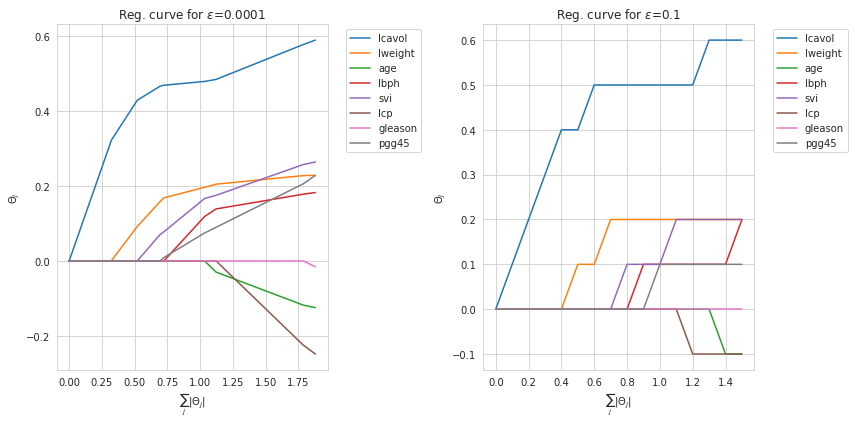

In [26]:
# Forward stagewise
plt.figure(figsize=(12,6))
for plot_i, epsilon in enumerate([1e-4, 1e-1], 1):  # Small epsilon yields smooth regularization curves
    theta = np.zeros((len(X_cols),))
    X = np.array(cancer_train_df[X_cols])
    r = np.array(cancer_train_df[Y_col])

    coefs = [np.array(theta)]
    errs = []
    last_err = np.sum(r**2)

    for _ in range(1000000):
        # compute correlations between residuals r and features in X
        residual_correlations = r @ X

        # choose best feature
        best_feat = np.argmax(np.abs(residual_correlations))
        max_corr = residual_correlations[best_feat]
        
        # increase the [absolute value] of coefficient correponding to the best feature
        theta[best_feat] += epsilon * np.sign(max_corr)
        # recompute the residuals and error
        r -= epsilon * np.sign(max_corr) * X[:, best_feat]
        cur_err = np.sum(r**2)

        if last_err - cur_err < 0:
            break
        last_err = cur_err
        errs.append(cur_err)
        coefs.append(np.array(theta))


    coefs = np.array(coefs).T
    tau = np.abs(coefs).sum(0)

    plt.subplot(1,2,plot_i)
    for i, name in enumerate(X_cols):
        plt.plot(tau, coefs[i], label=name)
    plt.ylabel(r'$\Theta_j$')
    plt.xlabel(r'$\sum_j|\Theta_j|$')
    plt.title(f'Reg. curve for $\epsilon$={epsilon}')
    _ = plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

### Least Angle Regression (LARS)

The Forward Stagewise procedure produces regularization curves which are a very useful tool in diagnosing the importance of features. Hovewer, the procedure was only heuristically justified, and is computationally intensive.

It turns out, that one can obtain the regularization curve of the Lasso objective using an algorithm, called LARS, which is very similar to the Forward Stagewise.

Full description of LARS is outside the scope of these notes, however intuitiely it works like that:

1. Start with $\Theta=0$, which corresponds to $\lambda \rightarrow \infty$.
2. In a loop:
    1. find the set of features most correlated with the residuals (errors).
    2. find exactly how much they can be increased, i.e. find the moment at which another feature enters the set of hihg correlation with the residuals.
    3. increase all active coefficients until the above point is met. Then extent the active coefficient set and repeat.

Thus, intuitively, LARS ressembles a faster variant of Forward Stagewise - it always increases all active coefficients by the maximum allowable amount. (Please note that there are subtle differences between Forward Stagewise and LARS. In particular, in LARS a feature may be selected for use, then removed from the active set).

Below we use the implementation from `sklearn`. We see that a full regularizatoin curve is returned, helping to choose to fully evaluate each feature's importance and choosing an optimal $\lambda$.

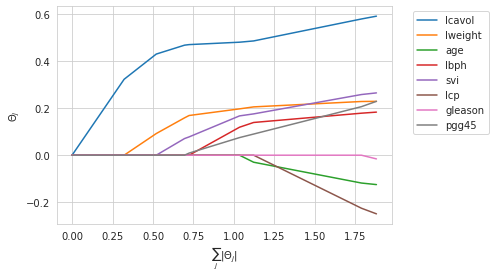

In [27]:
(alphas, active, coefs
 ) = sklearn.linear_model.lars_path(np.array(cancer_train_df[X_cols]), 
                                    np.array(cancer_train_df[Y_col]))
 
# coefs is D x n_steps
tau = np.abs(coefs).sum(0)

for i, name in enumerate(X_cols):
    plt.plot(tau, coefs[i], label=name)
plt.ylabel(r'$\Theta_j$')
plt.xlabel(r'$\sum_j|\Theta_j|$')
_ = plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

## Conclusions

In this note we have introduced the problem of optimal feature selection. We have also seen how this can correspond to a specially selected model prior. Finally, we have learned about a very practical method of feature selection called the Lasso, along with LARS - an efficient solver of the underlying optimization problem. 